# Deep Learning + Wang-Landau
---

Simple notebook implementing project. Replaces `main.py` in `deep_learning` package.

By: William Tong (wlt2115)

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt 
import numpy as np
from scipy.special import softmax
import tensorflow as tf

from deep_learning import model as md
from deep_learning import util

%matplotlib inline
%config IPCompleter.greedy=True

## Global configs

In [2]:
LOG_DIR = Path(r'/home/grandpaa/workspace/deep_learning/logs')

RUN_NAME = 'mnist/undersamp'
# TB_DIR = LOG_DIR / 'tensorboard' / RUN_NAME
WL_DIR = LOG_DIR / 'wang_landau' / RUN_NAME

## Helper functions

In [3]:
def _rand_sample(size: int, domain: tuple) -> np.ndarray:
    samp = np.random.random_sample(size) \
           * (domain[1] - domain[0]) \
           + domain[0]
    return samp

In [4]:
def _train_model(model: tf.keras.models.Model,
                 data: np.ndarray,
                 labels: np.ndarray,
                 epochs: int = 100,
                 val_data: np.ndarray = None,
                 val_labels: np.ndarray = None) -> 'Model':
    kwargs = {}
    if val_data is not None and val_labels is not None:
        kwargs['validation_data'] = (val_data, val_labels)

        tensorboard = tf.keras.callbacks.TensorBoard(log_dir=TB_DIR,
                                                     histogram_freq=2)
        kwargs['callbacks'] = [tensorboard]

    model.fit(data, labels,
              epochs=epochs, batch_size=32,
              **kwargs)
    return model

In [5]:
def _get_density(values: list) -> list:
    total = sum(values)
    densities = [value / total for value in values]
    
    return densities

## Define model / energy func

In [6]:
SAVE_PATH = r'/home/grandpaa/workspace/deep_learning/trained/mnist_model_undersamp.h5py'
model = tf.keras.models.load_model(SAVE_PATH)

# TODO: more robust change to shape of input

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
def energy_func(x: np.ndarray) -> int:
    x = x.reshape(1, 14, 14)
    pred = model.predict(x)
    return np.argmax(pred[0])

In [25]:
W, b = model.layers[-1].get_weights()
W = W.reshape(10, 128)
b = b.reshape(10, 1)

In [26]:
def energy_func_readout(x: np.ndarray) -> int:
    global W, b  
    
    x = x.reshape(128, 1)
    
    output = np.matmul(W, x) + b
    return np.argmax(softmax(output))

## Investigating domain

In [34]:
W_init, b_init = model.layers[1].get_weights()
W_init = W_init.reshape(128, 784)
b_init = b_init.reshape(128, 1)

def energy_func_init(x: np.ndarray) -> int:
    global W_init, b_init
    
    x = x.reshape(784, 1)
    
    return np.matmul(W_init, x) + b_init

In [44]:
record = np.zeros((128, 2)) # (input, max-min)

sample = _rand_sample(784 * 1000, (0, 1)).reshape(1000, 784)
record = np.concatenate((sample[0], sample[0])).reshape(-1, 2)
for row in sample[1:]:
    result = energy_func_init(row).reshape(-1)
    for i in range(len(result)):
        if result[i] > record[i][0]:
            record[i][0] = result[i]
        elif result[i] < record[i][1]:
            record[i][1] = result[i]

Max:  12.612918615734934
Min:  -13.988839367671396


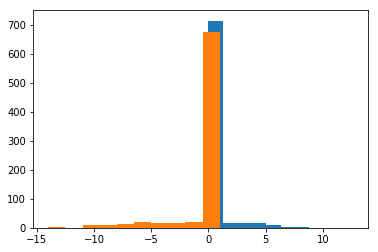

In [54]:
# for row in record:
#     print(row)
plt.hist(record[:,0])
plt.hist(record[:,1])

print('Max: ', max(record[:,0]))
print('Min: ', min(record[:,1]))

# Problem: how to characterize domain properly for WL sampling?

## Release the Dragons!

In [8]:
num_dims = 196

wl_configs = {
    'energy' : energy_func,
    
    'domain': np.array([0, 1]*num_dims).reshape(num_dims, -1),
    'energy_range': range(10),

    'flatness': 0.95,
    'step_size': 1,

    'max_iterations': 10000000,
    'check_every': 400,
    'save_every': 2000,
    'log_dir': WL_DIR
}

freqs, hist = util.wang_landau(**wl_configs)

INFO:root:Iteration 400 f=1.000000
INFO:root:At check, min: 0.000000 mean: 40.000000
INFO:root:Iteration 800 f=1.000000
INFO:root:At check, min: 0.000000 mean: 80.000000
INFO:root:Iteration 1200 f=1.000000
INFO:root:At check, min: 0.000000 mean: 120.000000
INFO:root:Iteration 1600 f=1.000000
INFO:root:At check, min: 0.000000 mean: 160.000000
INFO:root:Iteration 2000 f=1.000000
INFO:root:At check, min: 0.000000 mean: 200.000000
INFO:root:Iteration 2400 f=1.000000
INFO:root:At check, min: 0.000000 mean: 240.000000
INFO:root:Iteration 2800 f=1.000000
INFO:root:At check, min: 0.000000 mean: 280.000000
INFO:root:Iteration 3200 f=1.000000
INFO:root:At check, min: 0.000000 mean: 320.000000
INFO:root:Iteration 3600 f=1.000000
INFO:root:At check, min: 0.000000 mean: 360.000000
INFO:root:Iteration 4000 f=1.000000
INFO:root:At check, min: 0.000000 mean: 400.000000
INFO:root:Iteration 4400 f=1.000000
INFO:root:At check, min: 0.000000 mean: 440.000000
INFO:root:Iteration 4800 f=1.000000
INFO:root:A

INFO:root:Iteration 37200 f=0.500000
INFO:root:At check, min: 0.000000 mean: 200.000000
INFO:root:Iteration 37600 f=0.500000
INFO:root:At check, min: 0.000000 mean: 240.000000
INFO:root:Iteration 38000 f=0.500000
INFO:root:At check, min: 0.000000 mean: 280.000000
INFO:root:Iteration 38400 f=0.500000
INFO:root:At check, min: 254.000000 mean: 320.000000
INFO:root:Iteration 38800 f=0.500000
INFO:root:At check, min: 254.000000 mean: 360.000000
INFO:root:Iteration 39200 f=0.500000
INFO:root:At check, min: 254.000000 mean: 400.000000
INFO:root:Iteration 39600 f=0.500000
INFO:root:At check, min: 254.000000 mean: 440.000000
INFO:root:Iteration 40000 f=0.500000
INFO:root:At check, min: 254.000000 mean: 480.000000
INFO:root:Iteration 40400 f=0.500000
INFO:root:At check, min: 254.000000 mean: 520.000000
INFO:root:Iteration 40800 f=0.500000
INFO:root:At check, min: 254.000000 mean: 560.000000
INFO:root:Iteration 41200 f=0.500000
INFO:root:At check, min: 254.000000 mean: 600.000000
INFO:root:Iterat

INFO:root:Iteration 73600 f=0.125000
INFO:root:At check, min: 0.000000 mean: 1400.000000
INFO:root:Iteration 74000 f=0.125000
INFO:root:At check, min: 0.000000 mean: 1440.000000
INFO:root:Iteration 74400 f=0.125000
INFO:root:At check, min: 0.000000 mean: 1480.000000
INFO:root:Iteration 74800 f=0.125000
INFO:root:At check, min: 0.000000 mean: 1520.000000
INFO:root:Iteration 75200 f=0.125000
INFO:root:At check, min: 0.000000 mean: 1560.000000
INFO:root:Iteration 75600 f=0.125000
INFO:root:At check, min: 0.000000 mean: 1600.000000
INFO:root:Iteration 76000 f=0.125000
INFO:root:At check, min: 0.000000 mean: 1640.000000
INFO:root:Iteration 76400 f=0.125000
INFO:root:At check, min: 0.000000 mean: 1680.000000
INFO:root:Iteration 76800 f=0.125000
INFO:root:At check, min: 0.000000 mean: 1720.000000
INFO:root:Iteration 77200 f=0.125000
INFO:root:At check, min: 0.000000 mean: 1760.000000
INFO:root:Iteration 77600 f=0.125000
INFO:root:At check, min: 0.000000 mean: 1800.000000
INFO:root:Iteration 7

INFO:root:Iteration 110000 f=0.062500
INFO:root:At check, min: 700.000000 mean: 920.000000
INFO:root:Iteration 110400 f=0.062500
INFO:root:At check, min: 722.000000 mean: 960.000000
INFO:root:Iteration 110800 f=0.062500
INFO:root:At check, min: 824.000000 mean: 1000.000000
INFO:root:Iteration 111200 f=0.062500
INFO:root:At check, min: 847.000000 mean: 1040.000000
INFO:root:Iteration 111600 f=0.062500
INFO:root:At check, min: 847.000000 mean: 1080.000000
INFO:root:Iteration 112000 f=0.062500
INFO:root:At check, min: 976.000000 mean: 1120.000000
INFO:root:Iteration 112400 f=0.062500
INFO:root:At check, min: 994.000000 mean: 1160.000000
INFO:root:Iteration 112800 f=0.062500
INFO:root:At check, min: 1069.000000 mean: 1200.000000
INFO:root:Iteration 113200 f=0.062500
INFO:root:At check, min: 1115.000000 mean: 1240.000000
INFO:root:Iteration 113600 f=0.062500
INFO:root:At check, min: 1141.000000 mean: 1280.000000
INFO:root:Iteration 114000 f=0.062500
INFO:root:At check, min: 1156.000000 mean

INFO:root:Iteration 145600 f=0.031250
INFO:root:At check, min: 1133.000000 mean: 1440.000000
INFO:root:Iteration 146000 f=0.031250
INFO:root:At check, min: 1183.000000 mean: 1480.000000
INFO:root:Iteration 146400 f=0.031250
INFO:root:At check, min: 1211.000000 mean: 1520.000000
INFO:root:Iteration 146800 f=0.031250
INFO:root:At check, min: 1256.000000 mean: 1560.000000
INFO:root:Iteration 147200 f=0.031250
INFO:root:At check, min: 1318.000000 mean: 1600.000000
INFO:root:Iteration 147600 f=0.031250
INFO:root:At check, min: 1365.000000 mean: 1640.000000
INFO:root:Iteration 148000 f=0.031250
INFO:root:At check, min: 1404.000000 mean: 1680.000000
INFO:root:Iteration 148400 f=0.031250
INFO:root:At check, min: 1441.000000 mean: 1720.000000
INFO:root:Iteration 148800 f=0.031250
INFO:root:At check, min: 1460.000000 mean: 1760.000000
INFO:root:Iteration 149200 f=0.031250
INFO:root:At check, min: 1519.000000 mean: 1800.000000
INFO:root:Iteration 149600 f=0.031250
INFO:root:At check, min: 1562.00

INFO:root:At check, min: 0.000000 mean: 1640.000000
INFO:root:Iteration 181600 f=0.015625
INFO:root:At check, min: 0.000000 mean: 1680.000000
INFO:root:Iteration 182000 f=0.015625
INFO:root:At check, min: 0.000000 mean: 1720.000000
INFO:root:Iteration 182400 f=0.015625
INFO:root:At check, min: 0.000000 mean: 1760.000000
INFO:root:Iteration 182800 f=0.015625
INFO:root:At check, min: 0.000000 mean: 1800.000000
INFO:root:Iteration 183200 f=0.015625
INFO:root:At check, min: 0.000000 mean: 1840.000000
INFO:root:Iteration 183600 f=0.015625
INFO:root:At check, min: 0.000000 mean: 1880.000000
INFO:root:Iteration 184000 f=0.015625
INFO:root:At check, min: 0.000000 mean: 1920.000000
INFO:root:Iteration 184400 f=0.015625
INFO:root:At check, min: 0.000000 mean: 1960.000000
INFO:root:Iteration 184800 f=0.015625
INFO:root:At check, min: 0.000000 mean: 2000.000000
INFO:root:Iteration 185200 f=0.015625
INFO:root:At check, min: 0.000000 mean: 2040.000000
INFO:root:Iteration 185600 f=0.015625
INFO:root:

INFO:root:Iteration 217600 f=0.007812
INFO:root:At check, min: 0.000000 mean: 600.000000
INFO:root:Iteration 218000 f=0.007812
INFO:root:At check, min: 0.000000 mean: 640.000000
INFO:root:Iteration 218400 f=0.007812
INFO:root:At check, min: 0.000000 mean: 680.000000
INFO:root:Iteration 218800 f=0.007812
INFO:root:At check, min: 0.000000 mean: 720.000000
INFO:root:Iteration 219200 f=0.007812
INFO:root:At check, min: 50.000000 mean: 760.000000
INFO:root:Iteration 219600 f=0.007812
INFO:root:At check, min: 72.000000 mean: 800.000000
INFO:root:Iteration 220000 f=0.007812
INFO:root:At check, min: 83.000000 mean: 840.000000
INFO:root:Iteration 220400 f=0.007812
INFO:root:At check, min: 143.000000 mean: 880.000000
INFO:root:Iteration 220800 f=0.007812
INFO:root:At check, min: 204.000000 mean: 920.000000
INFO:root:Iteration 221200 f=0.007812
INFO:root:At check, min: 243.000000 mean: 960.000000
INFO:root:Iteration 221600 f=0.007812
INFO:root:At check, min: 271.000000 mean: 1000.000000
INFO:root

INFO:root:Iteration 253200 f=0.007812
INFO:root:At check, min: 3373.000000 mean: 4160.000000
INFO:root:Iteration 253600 f=0.007812
INFO:root:At check, min: 3423.000000 mean: 4200.000000
INFO:root:Iteration 254000 f=0.007812
INFO:root:At check, min: 3445.000000 mean: 4240.000000
INFO:root:Iteration 254400 f=0.007812
INFO:root:At check, min: 3476.000000 mean: 4280.000000
INFO:root:Iteration 254800 f=0.007812
INFO:root:At check, min: 3515.000000 mean: 4320.000000
INFO:root:Iteration 255200 f=0.007812
INFO:root:At check, min: 3558.000000 mean: 4360.000000
INFO:root:Iteration 255600 f=0.007812
INFO:root:At check, min: 3584.000000 mean: 4400.000000
INFO:root:Iteration 256000 f=0.007812
INFO:root:At check, min: 3639.000000 mean: 4440.000000
INFO:root:Iteration 256400 f=0.007812
INFO:root:At check, min: 3694.000000 mean: 4480.000000
INFO:root:Iteration 256800 f=0.007812
INFO:root:At check, min: 3739.000000 mean: 4520.000000
INFO:root:Iteration 257200 f=0.007812
INFO:root:At check, min: 3776.00

INFO:root:At check, min: 7050.000000 mean: 7680.000000
INFO:root:Iteration 288800 f=0.007812
INFO:root:At check, min: 7086.000000 mean: 7720.000000
INFO:root:Iteration 289200 f=0.007812
INFO:root:At check, min: 7138.000000 mean: 7760.000000
INFO:root:Iteration 289600 f=0.007812
INFO:root:At check, min: 7196.000000 mean: 7800.000000
INFO:root:Iteration 290000 f=0.007812
INFO:root:At check, min: 7221.000000 mean: 7840.000000
INFO:root:Iteration 290400 f=0.007812
INFO:root:At check, min: 7272.000000 mean: 7880.000000
INFO:root:Iteration 290800 f=0.007812
INFO:root:At check, min: 7296.000000 mean: 7920.000000
INFO:root:Iteration 291200 f=0.007812
INFO:root:At check, min: 7347.000000 mean: 7960.000000
INFO:root:Iteration 291600 f=0.007812
INFO:root:At check, min: 7397.000000 mean: 8000.000000
INFO:root:Iteration 292000 f=0.007812
INFO:root:At check, min: 7446.000000 mean: 8040.000000
INFO:root:Iteration 292400 f=0.007812
INFO:root:At check, min: 7494.000000 mean: 8080.000000
INFO:root:Itera

INFO:root:Iteration 323600 f=0.003906
INFO:root:At check, min: 0.000000 mean: 280.000000
INFO:root:Iteration 324000 f=0.003906
INFO:root:At check, min: 0.000000 mean: 320.000000
INFO:root:Iteration 324400 f=0.003906
INFO:root:At check, min: 0.000000 mean: 360.000000
INFO:root:Iteration 324800 f=0.003906
INFO:root:At check, min: 0.000000 mean: 400.000000
INFO:root:Iteration 325200 f=0.003906
INFO:root:At check, min: 0.000000 mean: 440.000000
INFO:root:Iteration 325600 f=0.003906
INFO:root:At check, min: 0.000000 mean: 480.000000
INFO:root:Iteration 326000 f=0.003906
INFO:root:At check, min: 0.000000 mean: 520.000000
INFO:root:Iteration 326400 f=0.003906
INFO:root:At check, min: 0.000000 mean: 560.000000
INFO:root:Iteration 326800 f=0.003906
INFO:root:At check, min: 0.000000 mean: 600.000000
INFO:root:Iteration 327200 f=0.003906
INFO:root:At check, min: 0.000000 mean: 640.000000
INFO:root:Iteration 327600 f=0.003906
INFO:root:At check, min: 0.000000 mean: 680.000000
INFO:root:Iteration 3

INFO:root:At check, min: 3490.000000 mean: 3840.000000
INFO:root:Iteration 359600 f=0.003906
INFO:root:At check, min: 3533.000000 mean: 3880.000000
INFO:root:Iteration 360000 f=0.003906
INFO:root:At check, min: 3588.000000 mean: 3920.000000
INFO:root:Iteration 360400 f=0.003906
INFO:root:At check, min: 3624.000000 mean: 3960.000000
INFO:root:Iteration 360800 f=0.003906
INFO:root:At check, min: 3624.000000 mean: 4000.000000
INFO:root:Iteration 361200 f=0.003906
INFO:root:At check, min: 3726.000000 mean: 4040.000000
INFO:root:Iteration 361600 f=0.003906
INFO:root:At check, min: 3754.000000 mean: 4080.000000
INFO:root:Iteration 362000 f=0.003906
INFO:root:At check, min: 3784.000000 mean: 4120.000000
INFO:root:Iteration 362400 f=0.003906
INFO:root:At check, min: 3794.000000 mean: 4160.000000
INFO:root:Iteration 362800 f=0.003906
INFO:root:At check, min: 3858.000000 mean: 4200.000000
INFO:root:Iteration 363200 f=0.003906
INFO:root:At check, min: 3884.000000 mean: 4240.000000
INFO:root:Itera

INFO:root:At check, min: 0.000000 mean: 2520.000000
INFO:root:Iteration 395600 f=0.001953
INFO:root:At check, min: 0.000000 mean: 2560.000000
INFO:root:Iteration 396000 f=0.001953
INFO:root:At check, min: 0.000000 mean: 2600.000000
INFO:root:Iteration 396400 f=0.001953
INFO:root:At check, min: 0.000000 mean: 2640.000000
INFO:root:Iteration 396800 f=0.001953
INFO:root:At check, min: 0.000000 mean: 2680.000000
INFO:root:Iteration 397200 f=0.001953
INFO:root:At check, min: 0.000000 mean: 2720.000000
INFO:root:Iteration 397600 f=0.001953
INFO:root:At check, min: 0.000000 mean: 2760.000000
INFO:root:Iteration 398000 f=0.001953
INFO:root:At check, min: 0.000000 mean: 2800.000000
INFO:root:Iteration 398400 f=0.001953
INFO:root:At check, min: 0.000000 mean: 2840.000000
INFO:root:Iteration 398800 f=0.001953
INFO:root:At check, min: 0.000000 mean: 2880.000000
INFO:root:Iteration 399200 f=0.001953
INFO:root:At check, min: 0.000000 mean: 2920.000000
INFO:root:Iteration 399600 f=0.001953
INFO:root:

INFO:root:At check, min: 5061.000000 mean: 6120.000000
INFO:root:Iteration 431600 f=0.001953
INFO:root:At check, min: 5140.000000 mean: 6160.000000
INFO:root:Iteration 432000 f=0.001953
INFO:root:At check, min: 5243.000000 mean: 6200.000000
INFO:root:Iteration 432400 f=0.001953
INFO:root:At check, min: 5333.000000 mean: 6240.000000
INFO:root:Iteration 432800 f=0.001953
INFO:root:At check, min: 5387.000000 mean: 6280.000000
INFO:root:Iteration 433200 f=0.001953
INFO:root:At check, min: 5411.000000 mean: 6320.000000
INFO:root:Iteration 433600 f=0.001953
INFO:root:At check, min: 5411.000000 mean: 6360.000000
INFO:root:Iteration 434000 f=0.001953
INFO:root:At check, min: 5548.000000 mean: 6400.000000
INFO:root:Iteration 434400 f=0.001953
INFO:root:At check, min: 5560.000000 mean: 6440.000000
INFO:root:Iteration 434800 f=0.001953
INFO:root:At check, min: 5560.000000 mean: 6480.000000
INFO:root:Iteration 435200 f=0.001953
INFO:root:At check, min: 5617.000000 mean: 6520.000000
INFO:root:Itera

INFO:root:Iteration 466800 f=0.001953
INFO:root:At check, min: 8685.000000 mean: 9680.000000
INFO:root:Iteration 467200 f=0.001953
INFO:root:At check, min: 9012.000000 mean: 9720.000000
INFO:root:Iteration 467600 f=0.001953
INFO:root:At check, min: 9205.000000 mean: 9760.000000
INFO:root:Iteration 468000 f=0.001953
INFO:root:At check, min: 9205.000000 mean: 9800.000000
INFO:root:Iteration 468400 f=0.001953
INFO:root:At check, min: 9205.000000 mean: 9840.000000
INFO:root:Iteration 468800 f=0.001953
INFO:root:At check, min: 9346.000000 mean: 9880.000000
INFO:root:Iteration 469200 f=0.001953
INFO:root:At check, min: 9549.000000 mean: 9920.000000
INFO:root:Histogram flat at iteration 469200


<Figure size 432x288 with 0 Axes>

## Parse results

bins:	 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
valus:	 [5547.259765625, 5545.427734375, 5551.232421875, 5551.220703125, 5533.12109375, 5550.626953125, 5548.759765625, 5549.876953125, 5546.759765625, 5546.02734375]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
densities:	  [0.006457200063225516, 0.0010337206209705527, 0.3430417113108778, 0.33904515431943555, 4.6740899470425265e-09, 0.18723851718880763, 0.028939162948344054, 0.08844521290481629, 0.0039164898142446305, 0.0018828261551879833]


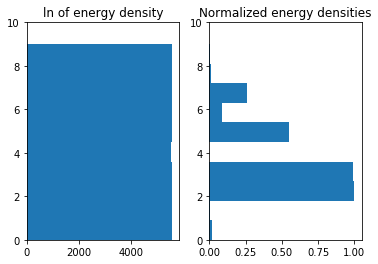

In [9]:
bins = list(freqs.keys())
values = list(freqs.values())
print('bins:\t', bins)
print('valus:\t', values)

plt.subplot(121)
plt.title("ln of energy density")
print(bins)
plt.hist(bins, weights=values, bins=len(bins), orientation='horizontal')
plt.ylim((0, 10))

plt.subplot(122)
max_val = max(values)
norm_values = [np.e ** (value - max_val) for value in values]
plt.title("Normalized energy densities")
plt.hist(bins, weights=norm_values, bins=len(bins), orientation='horizontal')
plt.ylim((0, 10))

print('densities:\t ', _get_density(norm_values))

## Manual verification

In [10]:
# line = np.arange(0, 50, 1)
# box = np.array([(x, y, z) for x in line for y in line for z in line])

# counts = list(range(10))
# energy_func = wl_configs['energy']
# for point in box:
#     counts[energy_func(point)] += 1

# brute_force_dens = _get_density(counts)
# print(brute_force_dens)